<h1>**Basic CNN Starter Code V0.2
**</h1>
In this small notebook I have created a basic sketch of a very simple CNN network. This is just bare bones and is meant to be just a schematic example of how to get about to implementing category identification using CNN. I have used multiple functions from various notebooks and I will add references. If i have missed some, please comment below. I will gladly add them. 

v 0.2 == Data Loader function added + Added a graph of model performance stats

COMMENTS WELCOME. CHEERS :)

data-processing references -
https://www.kaggle.com/xhlulu/rsna-intracranial-simple-densenet-in-keras


In [1]:
import numpy as np
from os import listdir
from os.path import isfile, join
import os
import pandas as pd
import pydicom
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
from tqdm import tqdm
from sklearn.utils import shuffle
import cv2
import pickle
import gc
import matplotlib.pyplot as plt
import keras
from tensorflow.python.keras.utils.data_utils import Sequence
from tensorflow.python.ops import array_ops


Using TensorFlow backend.


Declaration of various global quantities

In [2]:
batch_size=32
validation_ratio=0.1
sample_size=2000
epochs=3
img_size=512

Reading in the data

In [3]:
train = pd.read_csv('../input/rsna-intracranial-hemorrhage-detection/stage_1_train.csv')
train.shape
read_data = train.copy()
train.head()

,ID,Label
0,ID_63eb1e259_epidural,0
1,ID_63eb1e259_intraparenchymal,0
2,ID_63eb1e259_intraventricular,0
3,ID_63eb1e259_subarachnoid,0
4,ID_63eb1e259_subdural,0


Some quality of life improvements

In [4]:
train['filename'] = train['ID'].apply(lambda x: "ID_" + x.split('_')[1] + ".dcm")
train['type'] = train['ID'].apply(lambda x: x.split('_')[2])
train.head()

,ID,Label,filename,type
0,ID_63eb1e259_epidural,0,ID_63eb1e259.dcm,epidural
1,ID_63eb1e259_intraparenchymal,0,ID_63eb1e259.dcm,intraparenchymal
2,ID_63eb1e259_intraventricular,0,ID_63eb1e259.dcm,intraventricular
3,ID_63eb1e259_subarachnoid,0,ID_63eb1e259.dcm,subarachnoid
4,ID_63eb1e259_subdural,0,ID_63eb1e259.dcm,subdural


Now we combine all the similar data-points in a categorical way. This will enable us to easily extract the category vector.

In [5]:
train = train[['Label', 'filename', 'type']].drop_duplicates().pivot(
    index='filename', columns='type', values='Label').reset_index()
train.head()

type,filename,any,epidural,intraparenchymal,intraventricular,subarachnoid,subdural
0,ID_000039fa0.dcm,0,0,0,0,0,0
1,ID_00005679d.dcm,0,0,0,0,0,0
2,ID_00008ce3c.dcm,0,0,0,0,0,0
3,ID_0000950d7.dcm,0,0,0,0,0,0
4,ID_0000aee4b.dcm,0,0,0,0,0,0


We shuffle our data and take first <sample_size> data points.

In [6]:
train = shuffle(train)
train_sample=train
train_sample2=train_sample.reset_index(drop=True)

In [7]:
train_sample2.head()

type,filename,any,epidural,intraparenchymal,intraventricular,subarachnoid,subdural
0,ID_9a8728121.dcm,0,0,0,0,0,0
1,ID_7251b4f6b.dcm,0,0,0,0,0,0
2,ID_bf1d77a6e.dcm,0,0,0,0,0,0
3,ID_82a574033.dcm,1,0,1,1,1,0
4,ID_2cf498081.dcm,0,0,0,0,0,0


In [8]:
len(train_sample2)

674258

Now that we gave our input data set we can extract the categories out

In [9]:
yvals=pd.DataFrame(train_sample2,columns=['any','epidural','intraparenchymal','intraventricular','subarachnoid','subdural'])
yvals.head()

,any,epidural,intraparenchymal,intraventricular,subarachnoid,subdural
0,0,0,0,0,0,0
1,0,0,0,0,0,0
2,0,0,0,0,0,0
3,1,0,1,1,1,0
4,0,0,0,0,0,0


Similarly we will extract the image names of the relevant samples out.

In [10]:
xhead=pd.DataFrame(train_sample2,columns=['filename'])
xhead.head()

,filename
0,ID_9a8728121.dcm
1,ID_7251b4f6b.dcm
2,ID_bf1d77a6e.dcm
3,ID_82a574033.dcm
4,ID_2cf498081.dcm


Some fucntions to extract the correct window-image. These have been adapted from https://www.kaggle.com/allunia/rsna-ih-detection-eda and references therin

In [11]:
def window_image(img, window_center,window_width, intercept, slope, rescale=True):

    img = (img*slope +intercept)
    img_min = window_center - window_width//2
    img_max = window_center + window_width//2
    img[img<img_min] = img_min
    img[img>img_max] = img_max
    
    if rescale:
        # Extra rescaling to 0-1, not in the original notebook
        img = (img - img_min) / (img_max - img_min)
    
    return img
    
def get_first_of_dicom_field_as_int(x):
    #get x[0] as in int is x is a 'pydicom.multival.MultiValue', otherwise get int(x)
    if type(x) == pydicom.multival.MultiValue:
        return int(x[0])
    else:
        return int(x)

def get_windowing(data):
    dicom_fields = [data[('0028','1050')].value, #window center
                    data[('0028','1051')].value, #window width
                    data[('0028','1052')].value, #intercept
                    data[('0028','1053')].value] #slope
    return [get_first_of_dicom_field_as_int(x) for x in dicom_fields]

Since our data-set is too big to fit memory we will construct a function to use the data from the disk. This implementation is based on code written by,
https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly

In [12]:
class DataGenerator(Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs_labels, batch_size=100, dim=(512,512)):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.list_IDs = list_IDs_labels
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs['filename'][k] for k in indexes]
        list_label_temp=[[int(self.list_IDs['any'][i]),int(self.list_IDs['epidural'][i]),int(self.list_IDs['intraparenchymal'][i]),int(self.list_IDs['intraventricular'][i]),int(self.list_IDs['subarachnoid'][i]),int(self.list_IDs['subdural'][i])] for i in indexes]
        # Generate data
        X, y = self.__data_generation(list_IDs_temp,list_label_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))

    def __data_generation(self, list_IDs_temp,list_label_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = []
        y = []

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            ds=pydicom.dcmread('/kaggle/input/rsna-intracranial-hemorrhage-detection/stage_1_train_images/' +list_IDs_temp[i] )
            temp=ds.pixel_array
            window_center , window_width, intercept, slope = get_windowing(ds)
            img = window_image(temp, 50, 100, intercept, slope)
            resized = cv2.resize(img, (200, 200))
            X.append(resized)       
        X=np.array(X).reshape(-1,200,200,1)
        y_train=np.asarray(list_label_temp) 
        return X,y_train

For now we will train on a sample of 100000(16% of actual data) and use 20000 as validation

In [13]:
valid=train_sample2[100000:120000]
valid=valid.reset_index(drop=True)
valid.head()

type,filename,any,epidural,intraparenchymal,intraventricular,subarachnoid,subdural
0,ID_5b09acd5b.dcm,0,0,0,0,0,0
1,ID_04d02a142.dcm,0,0,0,0,0,0
2,ID_79956c9ed.dcm,0,0,0,0,0,0
3,ID_132434956.dcm,0,0,0,0,0,0
4,ID_b1edad893.dcm,0,0,0,0,0,0


In [14]:
traingen=DataGenerator(train_sample2[0:100000])
validgen=DataGenerator(valid)

Some old code that we wont need anymore

In [15]:
'''
X=[]
for i in tqdm(xhead.index):
    ds=pydicom.dcmread('/kaggle/input/rsna-intracranial-hemorrhage-detection/stage_1_train_images/' +xhead['filename'][i] )
    temp=ds.pixel_array
    window_center , window_width, intercept, slope = get_windowing(ds)
    img = window_image(temp, 50, 100, intercept, slope)
    resized = cv2.resize(img, (100, 100))
    X.append(resized)
pickle_out=open("/kaggle/X.pickle","wb")
pickle.dump(X,pickle_out)
pickle_out.close()
X=pickle.load(open("/kaggle/X.pickle","rb"))
X=np.array(X).reshape(-1,100,100,1)
y_train=[]
for i in tqdm(yvals.index):
    y_train.append([int(yvals['any'][i]),int(yvals['epidural'][i]),int(yvals['intraparenchymal'][i]),int(yvals['intraventricular'][i]),int(yvals['subarachnoid'][i]),int(yvals['subdural'][i])])
y_train=np.asarray(y_train) 
'''

'\nX=[]\nfor i in tqdm(xhead.index):\n    ds=pydicom.dcmread(\'/kaggle/input/rsna-intracranial-hemorrhage-detection/stage_1_train_images/\' +xhead[\'filename\'][i] )\n    temp=ds.pixel_array\n    window_center , window_width, intercept, slope = get_windowing(ds)\n    img = window_image(temp, 50, 100, intercept, slope)\n    resized = cv2.resize(img, (100, 100))\n    X.append(resized)\npickle_out=open("/kaggle/X.pickle","wb")\npickle.dump(X,pickle_out)\npickle_out.close()\nX=pickle.load(open("/kaggle/X.pickle","rb"))\nX=np.array(X).reshape(-1,100,100,1)\ny_train=[]\nfor i in tqdm(yvals.index):\n    y_train.append([int(yvals[\'any\'][i]),int(yvals[\'epidural\'][i]),int(yvals[\'intraparenchymal\'][i]),int(yvals[\'intraventricular\'][i]),int(yvals[\'subarachnoid\'][i]),int(yvals[\'subdural\'][i])])\ny_train=np.asarray(y_train) \n'

For an unbalanced data-set it is good to define a custom loss function like the focal loss. We will borrowed the code for this from https://www.kaggle.com/xhlulu/rsna-intracranial-simple-densenet-in-keras

In [16]:
def focal_loss(prediction_tensor, target_tensor, weights=None, alpha=0.25, gamma=2):
    r"""Compute focal loss for predictions.
        Multi-labels Focal loss formula:
            FL = -alpha * (z-p)^gamma * log(p) -(1-alpha) * p^gamma * log(1-p)
                 ,which alpha = 0.25, gamma = 2, p = sigmoid(x), z = target_tensor.
    Args:
     prediction_tensor: A float tensor of shape [batch_size, num_anchors,
        num_classes] representing the predicted logits for each class
     target_tensor: A float tensor of shape [batch_size, num_anchors,
        num_classes] representing one-hot encoded classification targets
     weights: A float tensor of shape [batch_size, num_anchors]
     alpha: A scalar tensor for focal loss alpha hyper-parameter
     gamma: A scalar tensor for focal loss gamma hyper-parameter
    Returns:
        loss: A (scalar) tensor representing the value of the loss function
    """
    sigmoid_p = tf.nn.sigmoid(prediction_tensor)
    zeros = array_ops.zeros_like(sigmoid_p, dtype=sigmoid_p.dtype)
    
    # For poitive prediction, only need consider front part loss, back part is 0;
    # target_tensor > zeros <=> z=1, so poitive coefficient = z - p.
    pos_p_sub = array_ops.where(target_tensor > zeros, target_tensor - sigmoid_p, zeros)
    
    # For negative prediction, only need consider back part loss, front part is 0;
    # target_tensor > zeros <=> z=1, so negative coefficient = 0.
    neg_p_sub = array_ops.where(target_tensor > zeros, zeros, sigmoid_p)
    per_entry_cross_ent = - alpha * (pos_p_sub ** gamma) * tf.log(tf.clip_by_value(sigmoid_p, 1e-8, 1.0)) \
                          - (1 - alpha) * (neg_p_sub ** gamma) * tf.log(tf.clip_by_value(1.0 - sigmoid_p, 1e-8, 1.0))
    return tf.reduce_sum(per_entry_cross_ent)

Now that we have both Input=X , Category=y_trest we can train a basic barebones model.
Here we have a model which is like ==   CNN -> CNN->  Flatten --> Dense ---> Dense(output)

In [17]:
model = Sequential()

model.add(Conv2D(32, (3, 3), input_shape=(200, 200,1)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32,(3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(5,5)))

model.add(Flatten())  

# model.add(Dense(100))
# model.add(Activation('relu'))

model.add(Dense(50))
model.add(Activation('relu'))

model.add(Dense(6))
model.add(Activation('sigmoid'))

# model.compile(loss='categorical_crossentropy',
#               optimizer='adam',
#               metrics=['accuracy'])
model.compile(loss=focal_loss,
               optimizer='adam',
               metrics=['accuracy'])

#model.fit(X,y_train,batch_size=32,epochs=6,validation_split=0.5)
history=model.fit_generator(generator=traingen,validation_data=validgen,use_multiprocessing=True,
                    workers=-1,epochs=2)

Epoch 1/2
1000/1000 [==============================] - 1096s 1s/step - loss: 0.1307 - acc: 0.8555 - val_loss: 0.1256 - val_acc: 0.8322
Epoch 2/2
1000/1000 [==============================] - 610s 610ms/step - loss: 0.1232 - acc: 0.8273 - val_loss: 0.1204 - val_acc: 0.7315


In [18]:
#history = model.fit(X, y_train, validation_split=0.25, epochs=20, batch_size=32, verbose=1)

Now that our result are looking half-decent we can improve the model further. To study any possible improvements, we need to first check out the statistics of our model and epochs. We will plot the accuracy and loss values.

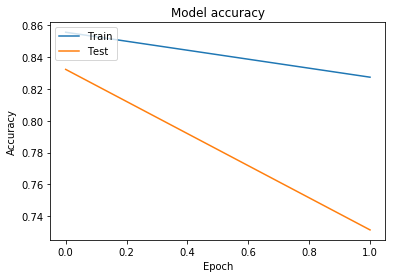

In [19]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


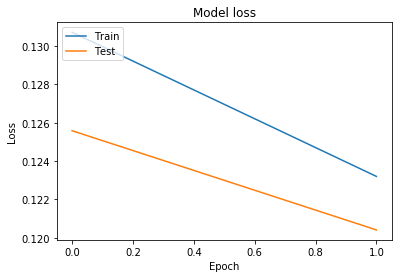

In [20]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()